Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

# Autoreload
%load_ext autoreload
%autoreload 2

# Set random seed
np.random.seed(0)

Data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")
(t_labels, t_data_raw, t_ids) = load_csv_data("data/test.csv")

# Select portion of data 

In [3]:
"""labels_raw_portion = labels_raw[:10000]
data_raw_portion = data_raw[:10000,:]
ids_raw_portion = ids_raw[:10000]"""

'labels_raw_portion = labels_raw[:10000]\ndata_raw_portion = data_raw[:10000,:]\nids_raw_portion = ids_raw[:10000]'

Data filtering and standardization
===

In [4]:
data_, data_t_, labels, ids = process_data(data_raw, t_data_raw, labels_raw, ids_raw, zero = False)
data, means, variance = standardize(data_)
data_t, means_t, var_t = standardize(data_t_)

The original dimensions of the training data set was 250000 samples and 30 columns. After feature and sample filtering, there are 223877 samples and 23 columns


Build data into matrix form
===

In [5]:
y, tx = build_model_data(data, labels)
y_t, tx_t = build_model_data(data_t,t_labels)

Splitting into train and test set
===

In [6]:
X_train, y_train, X_test, y_test = split_data(tx, y)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


Linear regression with gradient descent (GD)
===

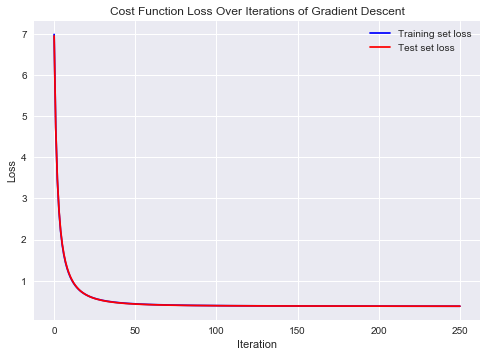

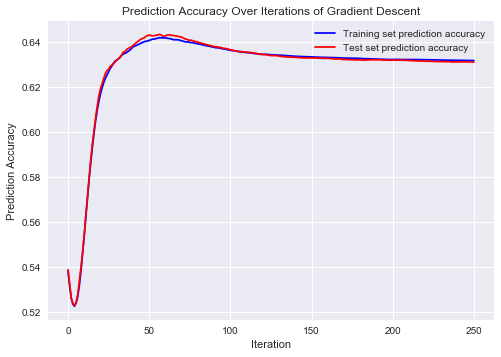

In [7]:
# initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_GD(y_train, X_train, initial_w, max_iters = 250) # fit model and retrieve W's across iterations
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()


Linear regression with stochastic gradient descent (SGD)
===

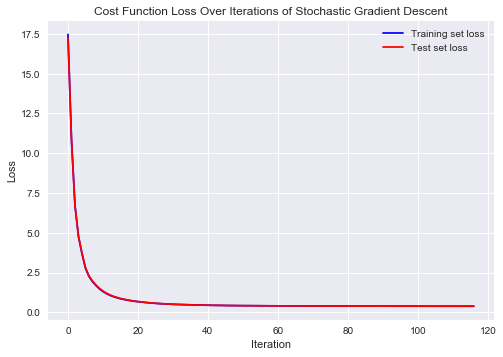

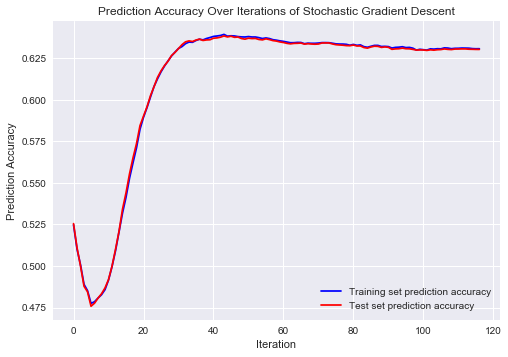

In [8]:
#initial_w = np.ones(X_train.shape[1])
initial_w = np.random.rand(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250, tol = 1e-4, patience = 5) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

In [9]:
w = least_squares(y_train, X_train)

pred_y = predict_labels(w, X_test)
pred_accuracy(pred_y,y_test)

0.629212730318258

Linear regression using the normal equations with additional polynomial degrees
===

degree: 1 	 rmse_ts: 0.8712791842883306 	  pred_ts: 0.629212730318258
degree: 2 	 rmse_ts: 1.307738160461525 	  pred_ts: 0.6603015075376885
degree: 3 	 rmse_ts: 8.657047295585132 	  pred_ts: 0.6763372417643775
degree: 4 	 rmse_ts: 72.25413277465204 	  pred_ts: 0.6810496929089894
degree: 5 	 rmse_ts: 555.827363556936 	  pred_ts: 0.6823003908431045
degree: 6 	 rmse_ts: 3876.078333753554 	  pred_ts: 0.6849581239530989
degree: 7 	 rmse_ts: 64089.434512778564 	  pred_ts: 0.6948520379676159
degree: 8 	 rmse_ts: 4260763.283877446 	  pred_ts: 0.7066890005583473
degree: 9 	 rmse_ts: 178057935.11081013 	  pred_ts: 0.7123171412618649
degree: 10 	 rmse_ts: 1795506259.7616863 	  pred_ts: 0.712607481853713
degree: 11 	 rmse_ts: 225558052693.5567 	  pred_ts: 0.7150418760469012
degree: 12 	 rmse_ts: 2759119719989.5815 	  pred_ts: 0.720178671133445
degree: 13 	 rmse_ts: 586369134112581.8 	  pred_ts: 0.7233054159687325
degree: 14 	 rmse_ts: 556402720681023.25 	  pred_ts: 0.722211055276382
degree: 15 	 r

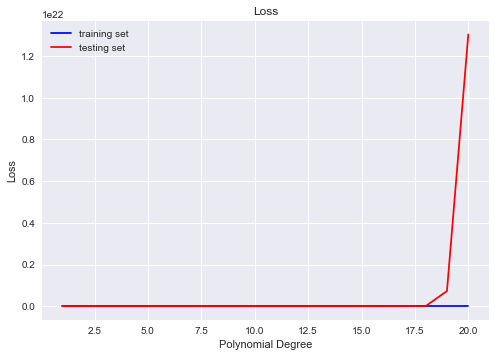

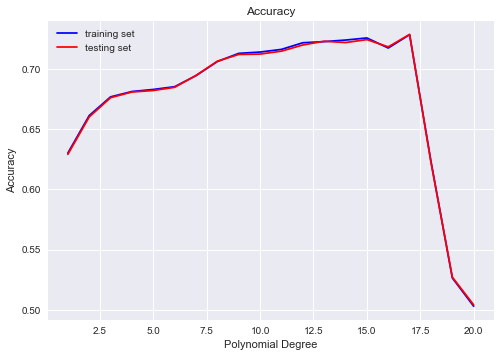

In [11]:
degrees = range(1,15)
rmse_tr = np.zeros(len(degrees))
rmse_ts = np.zeros(len(degrees))
pred_tr = np.zeros(len(degrees))
pred_ts = np.zeros(len(degrees))


for ind, degree in enumerate(degrees):
    #train the model
    X_test_poly = build_poly(X_test,degree)
    X_train_poly = build_poly(X_train,degree)
    w = least_squares(y_train, X_train_poly)
    rmse_tr[ind] = (np.sqrt(2 * compute_loss(y_train, X_train_poly, w)))
    pred_tr[ind] = pred_accuracy(predict_labels(w,X_train_poly),y_train)
    
    #test the model
    
    rmse_ts[ind] = (np.sqrt(2 * compute_loss(y_test, X_test_poly, w)))
    pred_ts[ind] = (pred_accuracy(predict_labels(w, X_test_poly),y_test))
    
    # print the update
    print("degree: {d} \t rmse_ts: {a} \t  pred_ts: {b}".format(d = degree, a = rmse_ts[ind], b = pred_ts[ind]))


    

# plot the loss
plt.style.use('seaborn')
plt.plot(degrees,rmse_tr, c='blue')
plt.plot(degrees,rmse_ts, c='red')
plt.title('Loss')
plt.xlabel('Polynomial Degree')
plt.ylabel('Loss')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


#plot the accuracy
plt.style.use('seaborn')
plt.plot(degrees,pred_tr, c='blue')
plt.plot(degrees,pred_ts, c='red')
plt.title('Accuracy')
plt.xlabel('Polynomial Degree')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.show()


Linear regression using ridge regression
===

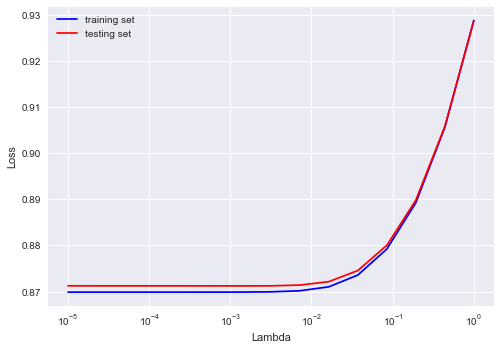

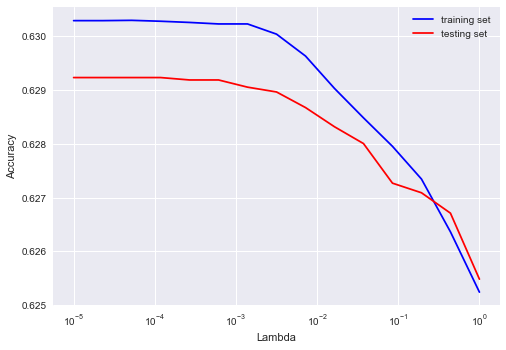

In [12]:
lambdas = np.logspace(-5, 0, 15)
rmse_tr = []
rmse_ts = []
pred_tr = []
pred_ts = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse_tr.append(np.sqrt(2 * compute_loss(y_train, X_train, w)))
    pred_tr.append(pred_accuracy(predict_labels(w, X_train),y_train))
    
    
    rmse_ts.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_ts.append(pred_accuracy(predict_labels(w, X_test),y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse_tr, c='blue')
plt.semilogx(lambdas,rmse_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

# print(np.max(pred))

# Logistic regression

C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:17: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))
C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:17: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))


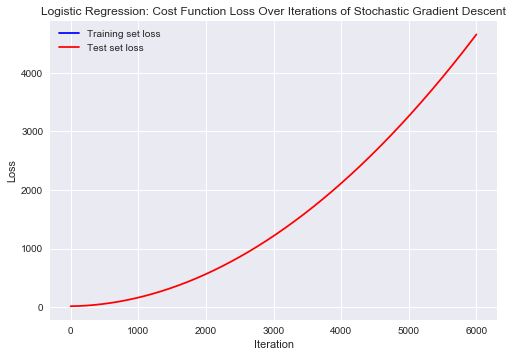

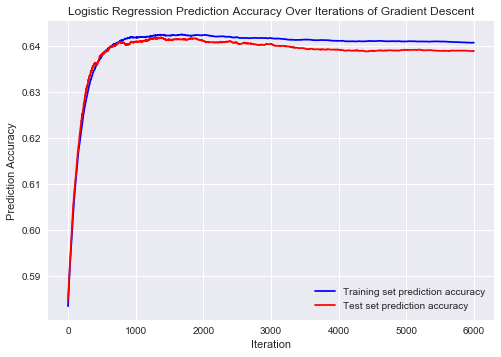

In [13]:
initial_w = np.random.rand(X_train.shape[1])
losses, ws = logistic_regression(y_train, X_train, initial_w, method = 'gd', max_iters = 6000) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'logistic'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Logistic Regression: Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()

# Regularized Logistic Regression

C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:20: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2
C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:20: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))) + 0.5 * lam * np.linalg.norm(w)) ** 2


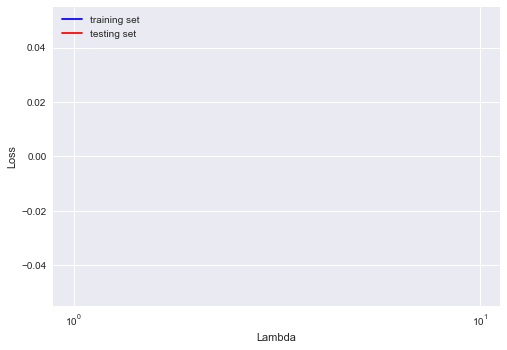

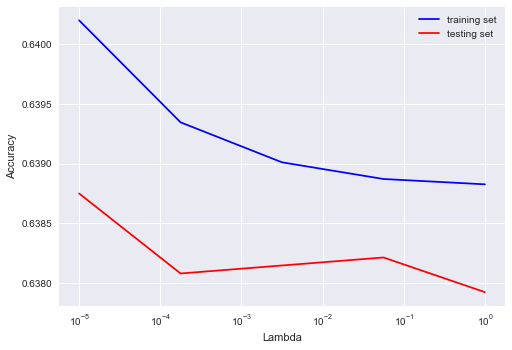

In [14]:
lambdas = np.logspace(-5, 0, 5)
loss_tr = []
loss_ts = []
pred_tr = []
pred_ts = []
initial_w = np.random.rand(X_train.shape[1])

# There is a runtime warning but just be patient

for ind, lambda_ in enumerate(lambdas):
    
    losses, ws = reg_logistic_regression(y_train, X_train, initial_w, lamb = lambda_, methods ='gd', gamma = 0.01, max_iters=6000)
    loss_tr.append(losses[-1])
    best_w = ws[-1]
    
    pred_tr.append(pred_accuracy(predict_labels(best_w, X_train),y_train))
    
    test_losses = compute_loss(y_test, X_test, best_w, lam = lambda_, method = 'reg_logistic') # retrieve losses using test set with ws
    loss_ts.append(test_losses)
    pred_ts.append(pred_accuracy(predict_labels(best_w, X_test),y_test))

    
plt.style.use('seaborn')
plt.semilogx(lambdas,loss_tr, c='blue')
plt.semilogx(lambdas,loss_ts, c='red')
plt.legend(['training set', 'testing set'], loc='upper left')
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred_tr, c='blue')
plt.semilogx(lambdas,pred_ts, c='red')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.legend(['training set', 'testing set'], loc='upper right')
plt.show()

####


In [15]:
# lamb = 0.1
# losses, ws = reg_logistic_regression(y_train, X_train, 
#                          initial_w, lamb, methods = 'gd', 
#                          gamma = 0.01, max_iters= 6000)

# test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, lam = lamb, method = 'reg_logistic'), ws)) # retrieve losses using test set with ws
# plt.style.use('seaborn')
# plt.plot(losses, label='Training set loss', c='blue')
# plt.plot(test_losses, label='Test set loss', c='red')
# plt.xlabel('Iteration')
# plt.ylabel('Loss')
# plt.title('Regularized Logistic Regression: Cost Function Loss Over Iterations of Gradient Descent')
# plt.legend()
# plt.show()

# # Make plot with label prediction accuracy

# pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
# pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
# pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
# pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


# plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
# plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
# plt.legend()
# plt.xlabel('Iteration')
# plt.ylabel('Prediction Accuracy')
# plt.title('Regularized Logistic Regression Prediction Accuracy Over Iterations of Gradient Descent')
# plt.show()

### Using the polynomial model

In [ ]:
degree = 12
X_test_poly = build_poly(data_test,degree)
X_train_poly = build_poly(data,degree)
w = least_squares(labels, X_train_poly)
rmse_tr = (np.sqrt(2 * compute_loss(labels, X_train_poly, w)))
pred_tr = pred_accuracy(predict_labels(w,X_train_poly),labels)

test_prediction = predict_labels(w, X_test_poly)
    

In [ ]:
name = "prediction.csv"
ids = ids_test
y_pred = test_prediction
create_csv_submission(ids, y_pred, name)

In [ ]:
print(test_prediction)

### Using logistic regression

In [20]:
initial_w = np.random.rand(tx.shape[1])
y[y == -1] = 0
losses, ws = logistic_regression(y, tx, initial_w, method = 'sgd', max_iters = 6000) # fit model, retrieve parameters ws

C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:17: RuntimeWarning: divide by zero encountered in log
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))
C:\Users\joao_\Documents\GitHub\machine_learning\project_1\implementations.py:17: RuntimeWarning: invalid value encountered in multiply
  loss = np.mean((-y * np.log(sigmoid(tx.dot(w))) - (1 - y) * np.log(1 - sigmoid(tx.dot(w)))))


In [23]:
pred = tx_t.dot(ws[-1])
pred[np.where(pred <= 0.5)] = -1
pred[np.where(pred > 0.5)] = 1

name = "prediction.csv"
create_csv_submission(t_ids, pred, name)

[[-297.70509331    3.49374762  -76.70692573 ...    1.39536525
     0.92849386   20.50607617]
 [-297.71758942    3.49382987  -76.71013926 ...    1.39536496
     0.92847424   20.50688931]
 [-297.73008553    3.49391212  -76.71335278 ...    1.39536467
     0.92845461   20.50770245]
 ...
 [-372.67623967    3.97433075  -95.99213808 ...    1.38011543
     0.7966628    25.36231725]
 [-372.68874209    3.97440918  -95.99535499 ...    1.38011039
     0.79663848   25.36312371]
 [-372.70124452    3.97448761  -95.99857191 ...    1.38010535
     0.79661415   25.36393017]]
